In [18]:
# wszystkie importy

import math 
import numpy as np          
import scipy.stats as stats             # rozklady 
import scipy.sparse as sparse           # generowanie wektorow rzadkich   
from matplotlib import pyplot as plt
from omp import omp                     # testowany algorytm
from itertools import combinations      # narzedzie do znajdowania wszystkich podzbiorow danego zbioru

# Narzędzia

In [19]:
# Funkcje zwiazane ze slownikami

def mu(slownik):
    '''funkcja przyjmujaca za argument slownik i zwracajaca jego parametr koherencji'''

    N = slownik.shape[1]        # ilosc kolumn     
    maxes = []   
    for i in range(N):          # petla po wszystkich kolumnach
        selector = list(range(N))
        selector.remove(i)       # chcemy wybrac wszystkie kolumny poza i-ta
        maxes.append( np.abs(slownik[:,selector].T.conj() @ slownik[:,i]).max() )
    
        

    maxes = np.array(maxes)
    return maxes.max()

# bardzo dlugo sie liczy, bedzie uzywana sporadycznie
def mu_1(m, slownik):
    '''funkcja przyjmujaca za argumenty liczbe naturalna m oraz slownik, zwracajaca wartosc
    funkcji skumulowanej spojnosci w punkcie m dla danego slownika'''

    if m == 0:
        return 0

    N = slownik.shape[1]

    indexes = range(N)
    prep = set(indexes)
    prep = combinations(prep, m)
    all_subsets = list(prep)

    maxes = []
    for subset in all_subsets:
        # iterowana zmienna subset jest m-elementowa krotka (uporzadkowana rosnaca) zawierajaca indeksy kolumn slownika
        subset_c = tuple(set(indexes) - set(subset))
        
        sums = []
        for i in subset_c:
            sums.append( np.abs(slownik[:,i].T.conj() @ slownik[:,subset]).sum() )
        
        sums = np.array(sums)
        maxes.append( sums.max() )

    maxes = np.array(maxes)
    return maxes.max()


In [20]:
# Generator wektorow losowych o roznych rozladach

def b_gen(slownik, dens = 0.1, rvs=None):
    '''
    Funkcja generujaca wektor rzadki b, mozliwe sa nastepujace parametry:
    slownik - slownik w ktorym wektor b jest reprezentowany,
    dens - gestosc wektora rzadkiego, gdy dens = 0.1, to co dziesiata wartosc bedzie niezerowa,
    rvs - rozklad prawdopodobienstwa.
    '''

    # obsluga argumentu rvs
    if rvs == None:
        rvs = stats.norm(loc=0, scale=1).rvs

    b = sparse.random(slownik.shape[1], 1, density=dens, data_rvs=rvs)
    return b.toarray()

# Poszukiwanie właściwego słownika

In [21]:
# Generator slownika do tego testu

def slownik1_gen(d, N):
    rng = np.random.default_rng()
    slownik = rng.integers(2, size=(d,N))
    slownik = slownik.astype(np.float64)

    slownik[slownik == 0] = -1/math.sqrt(d)
    slownik[slownik == 1] = 1/math.sqrt(d)

    return slownik

In [7]:
# ~-~-~-~-~-~-~-~-~-~-~-~ SKRYPT ~-~-~-~-~-~-~-~-~-~-~-~

N = 512         # ilosc atomow w generowanym slowniku
wyniki = []     # lista z wynikami (norma L_2 roznicy wartosci dokladnej i przyblizonej)
M = []          

for d in range(1, 1024):
    print(f'Aktualne parametry: d = {d}', end='\r')

    # inicjalizacja
    Phi = slownik1_gen(d, N)
    b = b_gen(Phi)
    s = Phi @ b

    #liczonko
    b_app = omp(Phi, s)

    # append wynikow
    wynik = math.sqrt( np.abs( np.conj((b-b_app).T) @ (b-b_app) ) )
    wyniki.append((d, wynik))
    M.append((d, mu(Phi)))

    # przeciez sprawdzanie b - b_app nie ma zadnego sensu...

In [ ]:
# zapisanie wynikow
wynikii = np.array(wyniki)
emm = np.array(M)

with open('wektory.npy', 'wb') as f:
    np.save(f, wynikii)
    np.save(f, emm)




In [5]:
# wczytanie wynikow testu 0
with open('wektory.npy', 'rb') as f:
    norms = np.load(f)
    mus = np.load(f)

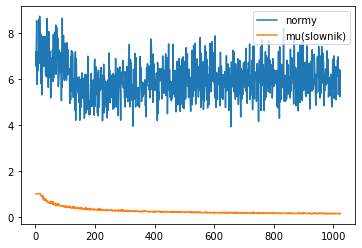

In [16]:
plt.plot(norms[:,0], norms[:,1], label='normy')
plt.plot(mus[:,0], mus[:,1], label='mu(slownik)')

plt.legend()

In [10]:
norms[:,:][norms[:,1] < 4.2]
mus[:,:][norms[:,1] < 4.2]

array([[1.35000000e+02, 3.62962963e-01],
       [1.49000000e+02, 3.69127517e-01],
       [2.25000000e+02, 2.97777778e-01],
       [3.27000000e+02, 2.41590214e-01],
       [4.09000000e+02, 2.37163814e-01],
       [6.56000000e+02, 1.73780488e-01],
       [7.49000000e+02, 1.66889186e-01]])

Podejście z liczeniem dokladnosci przyblizenia wektora b jest czasochlonne (I BEZ SENSU!), przez co nie pozwala na sprawdzenie duzej ilosci slownikow. Z pomoca przychodzi twierdzenie 5.14 z "A Mathematical Introduction to Compressive Sensing" oraz notatka pod koniec 5 rozdzialu, ktore mowia, ze aby odzyskac m rzadki wektor s wystarczy, ze mu < 1/2m-1

In [25]:
# sprawdzenie parametru koherencji slownika w zaleznosci od parametrow d i N
d_max = 1024
N_max = 512

coh_param_list = []
for N in (2**p for p in range(1, 11)):
    for d in range(1, d_max + 1):
        srednia_z_10 = []
        for i in range(10):
            print(f'Aktualne parametry: N = {N}, d = {d} ----', end='\r')
            Phi = slownik1_gen(d=d, N=N)
            coh_param = mu(Phi)
            srednia_z_10.append(coh_param)
        srednia_z_10 = np.array(srednia_z_10)
        srednia_z_10 = (srednia_z_10.sum()) / len(srednia_z_10)
        coh_param_list.append(srednia_z_10)
        
    

KeyboardInterrupt: 

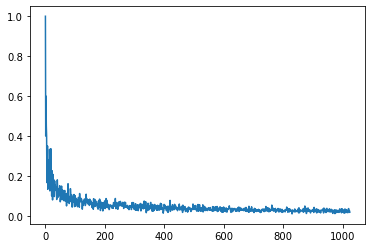

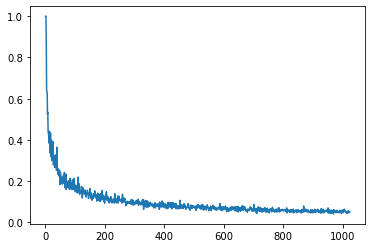

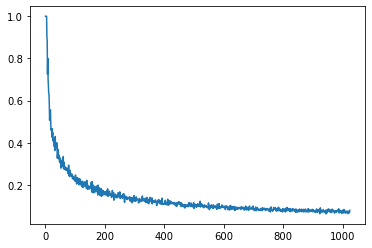

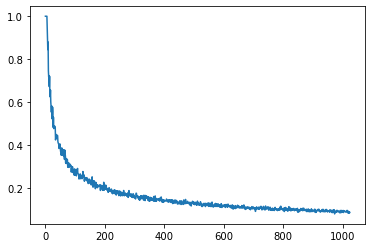

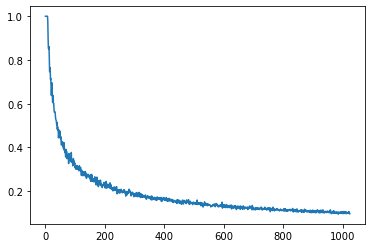

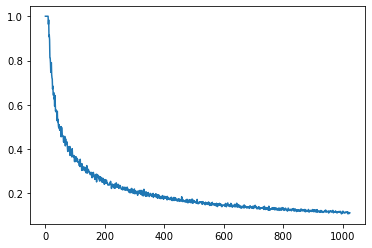

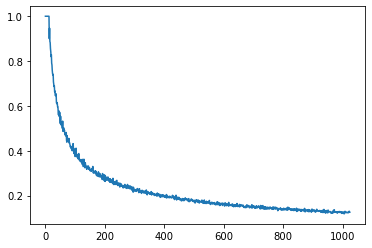

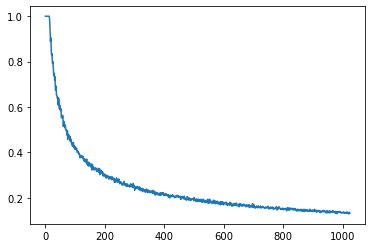

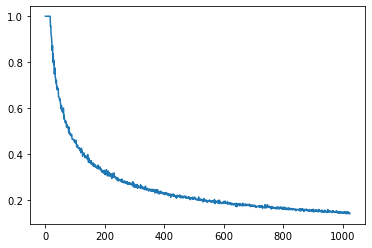

In [32]:
dane = np.array(coh_param_list)
len(dane[:9216])
dane = dane[:9216].reshape((9,1024))

for i in range(dane.shape[0]):
    plt.plot(dane[i,:])
    plt.show()

In [38]:
print(dane.shape)

(9, 1024)


In [6]:
Phi = slownik_gen(10, 10)
b = b_gen(Phi)
s = Phi @ b

print(f'Phi = {Phi}')
print(f'b = {b}')
print(f's = {s}')

b_app = omp(Phi, s)
print(f'b_app = {b_app}')

Phi = [[ 0.31622777 -0.31622777  0.31622777  0.31622777 -0.31622777  0.31622777
  -0.31622777  0.31622777  0.31622777  0.31622777]
 [-0.31622777  0.31622777  0.31622777 -0.31622777  0.31622777 -0.31622777
   0.31622777 -0.31622777  0.31622777  0.31622777]
 [-0.31622777  0.31622777 -0.31622777 -0.31622777 -0.31622777  0.31622777
   0.31622777  0.31622777  0.31622777 -0.31622777]
 [ 0.31622777 -0.31622777  0.31622777  0.31622777 -0.31622777  0.31622777
  -0.31622777 -0.31622777  0.31622777  0.31622777]
 [ 0.31622777  0.31622777  0.31622777 -0.31622777  0.31622777  0.31622777
   0.31622777  0.31622777 -0.31622777 -0.31622777]
 [ 0.31622777 -0.31622777  0.31622777 -0.31622777  0.31622777 -0.31622777
  -0.31622777 -0.31622777 -0.31622777 -0.31622777]
 [-0.31622777 -0.31622777  0.31622777 -0.31622777  0.31622777  0.31622777
  -0.31622777  0.31622777 -0.31622777  0.31622777]
 [-0.31622777 -0.31622777  0.31622777  0.31622777 -0.31622777  0.31622777
  -0.31622777 -0.31622777  0.31622777 -0.3162

In [ ]:
# Test 1 - SPRAWDZENIE POPRAWNOSCI IMPLEMENTACJI

In [ ]:
# Test 2A - TEST NA DANYCH RZECZYWISTYCH (plik muzyczny)

In [ ]:
# Test 2B - TEST NA DANYCH RZECZYWISTYCH (plik graficzny)

In [30]:
rng = np.random.default_rng()
slownik = rng.integers(2, size=(10,10))
slownik = slownik.astype(np.float64)

#slownik[slownik == 0] = -1/math.sqrt(d)
#slownik[slownik == 1] = 1/math.sqrt(d)

print(slownik)
liczba = -1/math.sqrt(10)
slownik[slownik == 0] = liczba
print(slownik)
type(slownik)

[[1. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
 [0. 1. 1. 0. 0. 0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 0. 1. 0.]]
[[ 1.         -0.31622777 -0.31622777  1.         -0.31622777  1.
  -0.31622777  1.         -0.31622777 -0.31622777]
 [-0.31622777  1.          1.         -0.31622777 -0.31622777 -0.31622777
   1.          1.         -0.31622777  1.        ]
 [ 1.         -0.31622777  1.         -0.31622777  1.         -0.31622777
   1.         -0.31622777  1.         -0.31622777]
 [ 1.         -0.31622777 -0.31622777  1.          1.         -0.31622777
   1.         -0.31622777 -0.31622777  1.        ]
 [-0.31622777  1.         -0.31622777  1.         -0.31622777  1.
  -0.31622777 -0.31622777 -0.31622777  1.        ]
 [-0.31622777 -0.31622777 -0.31622777  1.         -0.3162277

numpy.ndarray